In [18]:
%matplotlib inline
from scanner import Scanner
from skimage import io, color, util
from matplotlib import pyplot as plt
from PIL import Image
from bresenham import Bresenham
import pydicom
import numpy as np
import math
import tempfile
import datetime

# Setupowanie zmiennych:
detectors = 300
step = 0.008
angle_spread = math.pi
photo = './out.dcm'

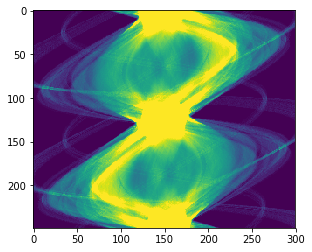

In [19]:
def normalize(num, bot, top):
    if num > top:
        return 1
    if num < bot:
        return 0
    return (num - bot)/(top - bot)


def normalize_photo(photo):
    bot, top = np.percentile(photo, (2, 90))
    print(bot, top)
    res = [[normalize(num, bot, top) for num in x] for x in photo]
    return res

img = None

if(photo[-4:] == '.dcm'):
    dcm_data = None
    with open(photo, 'rb') as infile:
        dcm_data = pydicom.dcmread(infile)
    img = dcm_data.pixel_array
else:
    img = io.imread(photo)

img = color.rgb2gray(img)

plt.imshow(img)
plt.show()

Radon
0.0 8779.996231894751


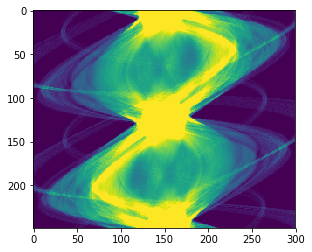

In [3]:
scan = Scanner(img, Bresenham).to_square_img()
scan.set_sampling_params(step, angle_spread, detectors)
sinogram = normalize_photo(scan.generate_sinogram())
plt.imshow(sinogram)
plt.show()

Odwracamy radona
0.0 36.434150958794895


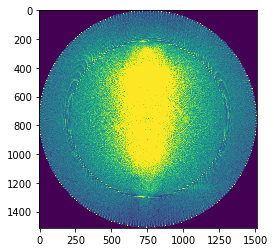

In [4]:
inversed_photo = scan.inverse_radon_transform(sinogram)
inversed_photo = normalize_photo(inversed_photo)
plt.imshow(inversed_photo)
plt.show()

In [17]:
sinogram = np.array(sinogram)

#Meta info
meta = pydicom.Dataset()
meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
meta.MediaStorageSOPInstanceUID = "1.2.3"
meta.ImplementationClassUID = "1.2.3.4"

ds2 = pydicom.FileDataset("out.dcm", {}, file_meta=meta, preamble=b"\0" * 128)

out = sinogram * 255
out = out.astype('uint16')

# Tutaj wprowadź dane pacjenta
ds2.PatientName = "Michał Nowak"
ds2.PatientID = "123125"
ds2.PatientSex = "M"
ds2.PatientAge = "35"
ds2.PatientWeight = "92"
ds2.PixelData = Image.fromarray(out).tobytes()
ds2.ImageComment = "Przekrój głowy"

# Ustawianie daty badania na teraz i zapis do pliku
dt = datetime.datetime.now()
ds2.ContentDate = dt.strftime('%Y%m%d')
timeStr = dt.strftime('%H%M%S.%f')
ds2.ContentTime = timeStr
ds2.is_little_endian = True
ds2.is_implicit_VR = True
ds2.BitsAllocated = 16
ds2.Rows = sinogram.shape[0]
ds2.Columns = sinogram.shape[1]
ds2.PixelRepresentation = 0
ds2.SamplesPerPixel = 1
ds2.PhotometricInterpretation = "MONOCHROME2"
ds2.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRBigEndian

ds2.save_as("out.dcm")

print("Saved sinogram to file.")

Saved sinogram to file.
